参考：https://zhuanlan.zhihu.com/p/468992765

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset

plt.style.use('default')
np.set_printoptions(precision=3,
                    threshold=1000,
                    edgeitems=1000,
                    linewidth=1000,
                    suppress=True)
n_clients = 3
dirichlet_alpha = 1.0
seed = 0  # 42
np.random.seed(seed)


def dirichlet_split_noniid(train_labels, alpha, n_clients):
    '''
    按照参数为alpha的Dirichlet分布将样本索引集合划分为n_clients个子集
    '''
    # 最大标签
    n_classes = train_labels.max()+1
    # (n_classes, n_clients) 类别标签分布矩阵X，记录每个类别划分到每个client去的比例
    label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes)
    # print(label_distribution.shape)
    # print(label_distribution)
    # (n_classes, ...) 记录n_classes个类别对应的样本索引集合
    # print(np.argwhere(train_labels == 0))
    class_idcs = [np.argwhere(train_labels == y).flatten()
                  for y in range(n_classes)]

    # 记录n_clients个client分别对应的样本索引集合
    client_idcs = [[] for _ in range(n_clients)]
    for k_idcs, fracs in zip(class_idcs, label_distribution):
        # k_idcs: 类别为k的样本索引集合
        # fracs: 类别为k的样本分配到n_clients个client的比例
        # print(len(k_idcs), len(fracs))
        # np.split按照比例fracs将类别为k的样本索引k_idcs划分为了n_clients个子集
        # i表示第i个client，idcs表示其对应的样本索引集合idcs
        # print(fracs)
        # print(np.cumsum(fracs))  # 累计和, 用于划分
        # print(np.cumsum(fracs)[:-1]*len(k_idcs))
        # print((np.cumsum(fracs)[:-1]*len(k_idcs)).astype(int))
        # 得到分割点
        split_point = np.split(
            k_idcs, (np.cumsum(fracs)[:-1]*len(k_idcs)).astype(int))
        # print([len(point) for point in split_point])
        for i, idcs in enumerate(split_point):
            # print(i, len(idcs), type(idcs))
            # 每个客户端加入对应的样本索引集合
            client_idcs[i] += [idcs]
        # break

    client_idx = [np.concatenate(idcs).tolist() for idcs in client_idcs]

    return client_idx


train_data = datasets.CIFAR10(
    root="./data/", download=True, train=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(
    root="./data/", download=True, train=False, transform=transforms.ToTensor())
classes = train_data.classes
n_classes = len(classes)
labels = np.concatenate(
    [np.array(train_data.targets), np.array(test_data.targets)], axis=0)
dataset = ConcatDataset([train_data, test_data])

# 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
client_idcs = dirichlet_split_noniid(
    labels, alpha=dirichlet_alpha, n_clients=n_clients)
dataset1 = [dataset[i] for i in client_idcs[0]]
# [print(len(i)) for i in client_idcs]
# print(dataset1[0])

Files already downloaded and verified
Files already downloaded and verified


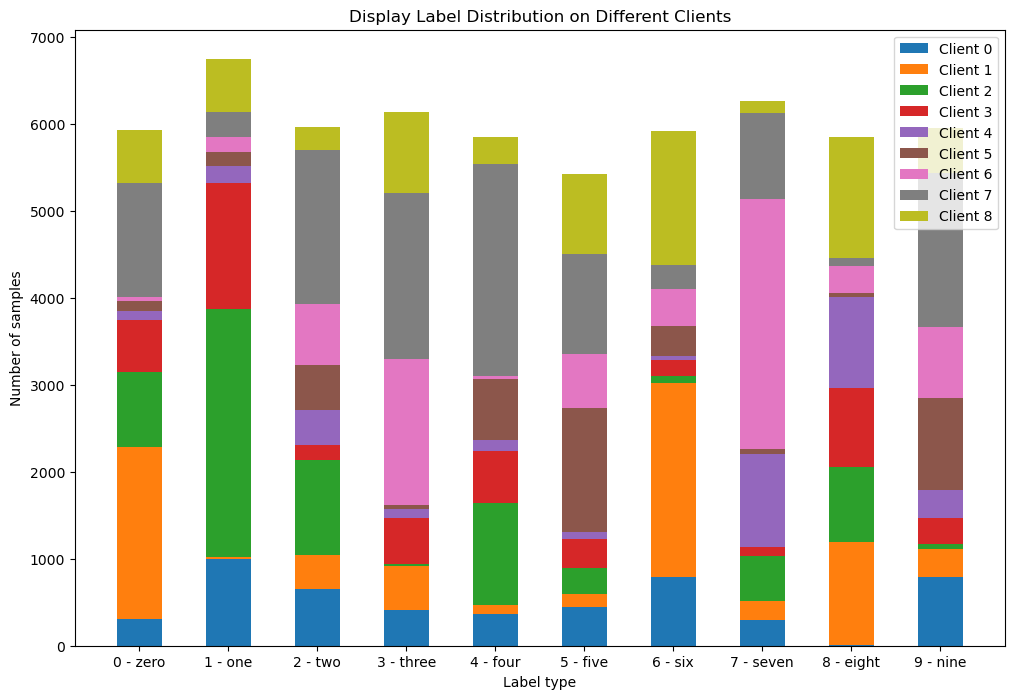

In [2]:
n_clients = 9
dirichlet_alpha = 1.0
seed = 42


if __name__ == "__main__":
    np.random.seed(seed)
    # train_data = datasets.EMNIST(
    #     root="./data/", split="byclass", download=True, train=True)
    # test_data = datasets.EMNIST(
    #     root="./data/", split="byclass", download=True, train=False)
    train_data = datasets.MNIST(
        root="./data/", download=True, train=True)
    test_data = datasets.MNIST(
        root="./data/", download=True, train=False)

    classes = train_data.classes
    n_classes = len(classes)

    # labels = np.concatenate(
    #     [np.array(train_data.targets), np.array(test_data.targets)], axis=0)
    # dataset = ConcatDataset([train_data, test_data])
    labels = np.array(train_data.targets)

    # 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
    client_idcs = dirichlet_split_noniid(
        labels, alpha=dirichlet_alpha, n_clients=n_clients)

    # 展示不同label划分到不同client的情况
    plt.figure(figsize=(12, 8))
    plt.hist([labels[idc]for idc in client_idcs], stacked=True,
             bins=np.arange(min(labels)-0.5, max(labels) + 1.5, 1),
             label=["Client {}".format(i) for i in range(n_clients)],
             rwidth=0.5)
    plt.xticks(np.arange(n_classes), train_data.classes)
    plt.xlabel("Label type")
    plt.ylabel("Number of samples")
    plt.legend(loc="upper right")
    plt.title("Display Label Distribution on Different Clients")
    plt.show()

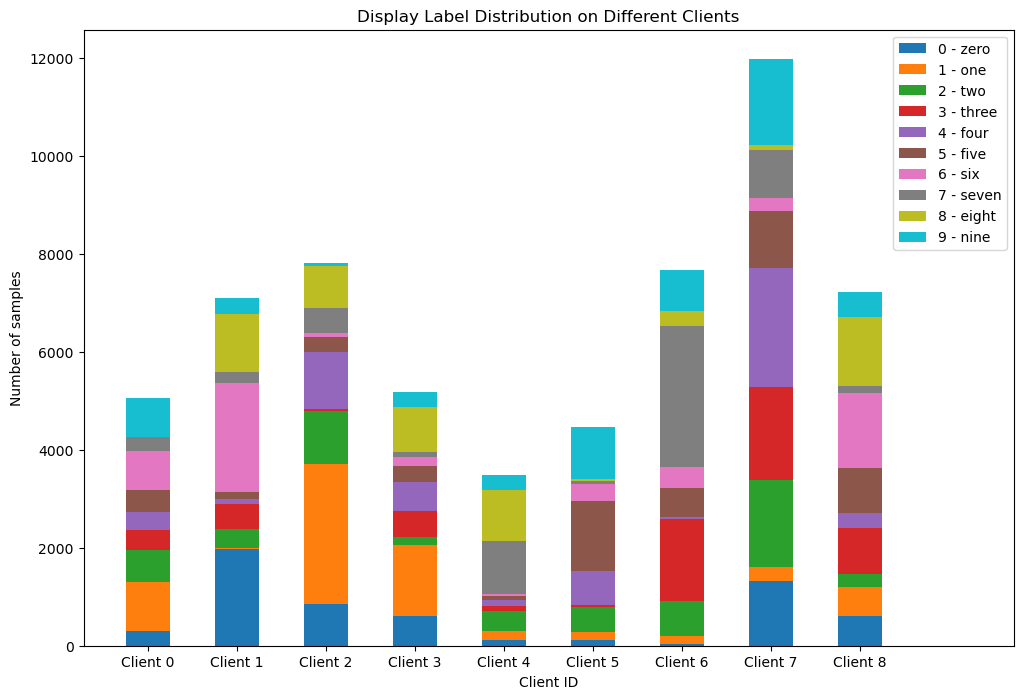

In [3]:
# 展示不同client上的label分布
plt.figure(figsize=(12, 8))
label_distribution = [[] for _ in range(n_classes)]
for c_id, idc in enumerate(client_idcs):
    for idx in idc:
        label_distribution[labels[idx]].append(c_id)

plt.hist(label_distribution, stacked=True,
            bins=np.arange(-0.5, n_clients + 1.5, 1),
            label=classes, rwidth=0.5)
plt.xticks(np.arange(n_clients), ["Client %d" %
                                    c_id for c_id in range(n_clients)])
plt.xlabel("Client ID")
plt.ylabel("Number of samples")
plt.legend()
plt.title("Display Label Distribution on Different Clients")
plt.show()

修改后，我自己用的代码

In [ ]:
import numpy as np
from torchvision.datasets import MNIST, CIFAR10, CIFAR100


class GetDataset:
    def __init__(
        self,
            dataset_name: str = 'mnist'
    ) -> None:
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        if dataset_name == 'mnist':
            self.__mnist_set()
        elif dataset_name == 'cifar10':
            self.__cifar10_set()
        elif dataset_name == 'cifar100':
            self.__cifar100_set()
        else:
            raise ValueError('dataset error.')

    def __trans(self, mean, std):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __mnist_set(self):
        self.train_set = MNIST(
            root='./data',
            train=True,
            download=True,
            transform=self.__trans((0.1307,), (0.3081,))
        )
        self.test_set = MNIST(
            root='./data',
            train=False,
            transform=self.__trans((0.1326,), (0.3106,))
        )
        self.n_targets = 10
        self.in_channel = 1

    def __cifar10_set(self):
        self.train_set = CIFAR10(
            root='./data',
            train=True,
            download=True,
            transform=self.__trans(mean=(0.4914, 0.4822, 0.4465),
                                   std=(0.2470, 0.2435, 0.2616)),
        )
        self.test_set = CIFAR10(
            root='./data',
            train=False,
            transform=self.__trans(mean=(0.4940, 0.4850, 0.4504),
                                   std=(0.2467, 0.2429, 0.2616)),
        )
        self.n_targets = 10
        self.in_channel = 3

    def __cifar100_set(self):
        self.train_set = CIFAR100(
            root='./data',
            train=True,
            download=True,
            transform=self.__trans(mean=(0.5071, 0.4865, 0.4409),
                                   std=(0.2009, 0.1984, 0.2023)),
        )
        self.test_set = CIFAR100(
            root='./data',
            train=False,
            transform=self.__trans(mean=(0.5088, 0.4874, 0.4419),
                                   std=(0.2019, 0.2000, 0.2037)),
        )
        self.n_targets = 100
        self.in_channel = 3


def dirichlet_split_noniid(train_labels, n_clients, n_classes, label_distribution):
    class_idcs = [np.argwhere(np.array(train_labels) == y).flatten()
                  for y in range(n_classes)]
    client_idcs = [[] for _ in range(n_clients)]
    for k_idcs, fracs in zip(class_idcs, label_distribution):
        split_point = np.split(
            k_idcs, (np.cumsum(fracs)[:-1]*len(k_idcs)).astype(int))
        for i, idcs in enumerate(split_point):
            client_idcs[i] += idcs.tolist()
    return client_idcs


def dirichlet_split(
        dataset_name: str = 'mnist',
        alpha: float or int = 1,
        n_clients: int = 3,
):

    dataset = GetDataset(dataset_name)
    n_targets = dataset.n_targets
    alpha = float(alpha)
    label_distribution = np.random.dirichlet(
        [alpha]*n_clients, dataset.n_targets)

    train_idx = dirichlet_split_noniid(
        train_labels=dataset.train_set.targets,
        n_clients=n_clients,
        n_classes=dataset.n_targets,
        label_distribution=label_distribution
    )
    test_idx = dirichlet_split_noniid(
        train_labels=dataset.test_set.targets,
        n_clients=n_clients,
        n_classes=dataset.n_targets,
        label_distribution=label_distribution
    )
    train_set, test_set = {}, {}
    for i in range(n_clients):
        train_set[i] = [dataset.train_set[j] for j in train_idx[i]]
        test_set[i] = [dataset.test_set[j] for j in test_idx[i]]

    return train_set, test_set, n_targets